In [1]:
%matplotlib inline


In [2]:
%pip install scipy
%pip install biotite


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



# Docking biotin to streptavidin

This example shows how to use *AutoDock Vina* :footcite:`Trott2010`
from within *Biotite* for docking a ligand molecule to a known receptor
structure.
As example, we examine the famous streptavidin-biotin interaction.

At first we download a high resolution structure of the complex.
The resolution is important here:
For one thing, the docking procedure requires annotated hydrogen atoms
for the receptor molecule, which seldom is the case for low resolution
X-ray structures.
On the other hand, we would like to have a reliable reference binding
mode of the ligand, to evaluate how well out docking procedure went

After separation of the receptor and the reference ligand,
a biotin model is loaded from the chemical components dictionary and
docked into the binding cavity of streptavidin.

Finally, the docked model is compared to the reference model, with
respect to their RMSD.

.. footbibliography::


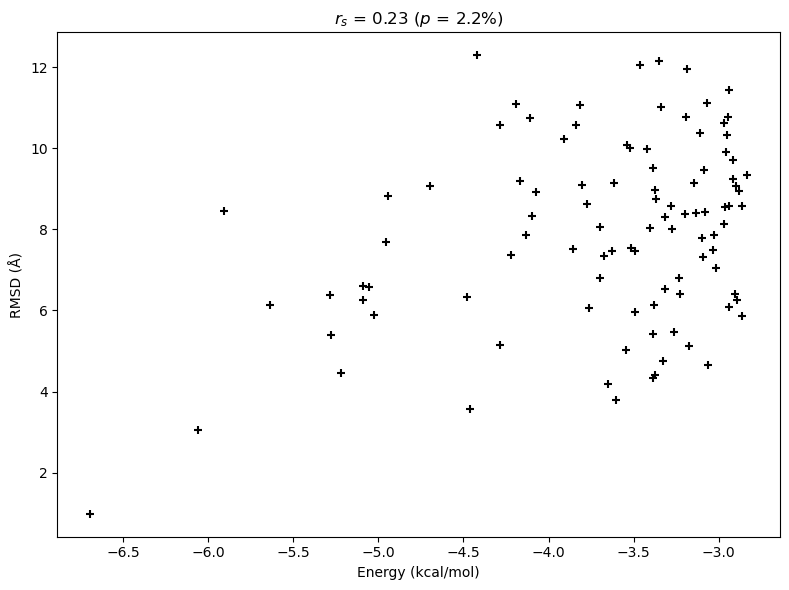

In [2]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import biotite.structure as struc
import biotite.structure.info as info
import biotite.structure.io.mmtf as mmtf
import biotite.structure.graphics as graphics
import biotite.database.rcsb as rcsb
import biotite.application.autodock as autodock


# Get the receptor structure
# and the original 'correct' conformation of the ligand
mmtf_file = mmtf.MMTFFile.read(rcsb.fetch("2RTG", "mmtf"))
structure = mmtf.get_structure(
    # Include formal charge for accurate partial charge calculation
    mmtf_file,
    model=1,
    include_bonds=True,
    extra_fields=["charge"],
)
# The asymmetric unit describes a streptavidin homodimer
# However, we are only interested in a single monomer
structure = structure[structure.chain_id == "B"]
receptor = structure[struc.filter_amino_acids(structure)]

ref_ligand = structure[structure.res_name == "BTN"]
ref_ligand_center = struc.centroid(ref_ligand)


# Independently, get the ligand without optimized conformation
# from the chemical components dictionary
ligand = info.residue("BTN")

# Search for a binding mode in a 20 Å radius
# of the original ligand position
app = autodock.VinaApp(ligand, receptor, ref_ligand_center, [20, 20, 20], bin_path="./vina")
# For reproducibility
app.set_seed(0)
# This is the maximum number:
# Vina may find less interesting binding modes
# and thus output less models
app.set_max_number_of_models(100)
# Effectively no limit
app.set_energy_range(100.0)
# Start docking run
app.start()
app.join()
docked_coord = app.get_ligand_coord()
energies = app.get_energies()

# Create an AtomArrayStack for all docked binding modes
docked_ligand = struc.from_template(ligand, docked_coord)
# As Vina discards all nonpolar hydrogen atoms, their respective
# coordinates are NaN -> remove these atoms
docked_ligand = docked_ligand[..., ~np.isnan(docked_ligand.coord[0]).any(axis=-1)]


# For comparison of the docked pose with the experimentally determined
# reference conformation, the atom order of both must be exactly the
# same
# Therefore, all atoms, that are additional in one of both models,
# e.g. carboxy or nonpolar hydrogen atoms, are removed...
docked_ligand = docked_ligand[..., np.isin(docked_ligand.atom_name, ref_ligand.atom_name)]
docked_ligand = docked_ligand[..., info.standardize_order(docked_ligand)]
# ...and the atom order is standardized
ref_ligand = ref_ligand[np.isin(ref_ligand.atom_name, docked_ligand.atom_name)]
ref_ligand = ref_ligand[info.standardize_order(ref_ligand)]

# print("docked_ligand in main", docked_ligand)

# Calculate the RMSD of the docked models to the correct binding mode
# No superimposition prior to RMSD calculation, as we want to see
# conformation differences with respect to the binding pocket
rmsd = struc.rmsd(ref_ligand, docked_ligand)

# Evaluate correlation between RMSD and binding energies
correlation, p_value = spearmanr(energies, rmsd)

figure, ax = plt.subplots(figsize=(8.0, 6.0))
ax.set_title(f"$r_s$ = {correlation:.2f} ($p$ = {p_value*100:.1f}%)")
ax.scatter(energies, rmsd, marker="+", color="black")
ax.set_xlabel("Energy (kcal/mol)")
ax.set_ylabel("RMSD (Å)")
figure.tight_layout()
plt.show()

For this specific case *AutoDock Vina* shows only a low Spearman
correlation between the RMSD of the calculated models to the
correct binding mode and the associated calculated binding energy.
A high correlation is desireable to ensure that docking results with
good binding energies correspond to the correct binding mode for cases
in which the correct binding conformation is unknown.
However, at least the calculated model with highest predicted affinity
is also the conformation with the lowest deviation from the
experimental result in this instance.
Hence, *AutoDock Vina* was able to predict an almost correct
binding mode as its best *guess*.

In a final step, we want to visually compare the experimentally
determined conformation of biotin in the binding pocket with the
minimum-energy docked conformation, which is also the conformation
with the lowest RMSD in this case.
The docked conformation is shown as ball-and-stick model, the original
experimentally determined biotin conformation is shown in transparent
blue. 



In [3]:
# Get the best fitting model,
# i.e the model with the lowest RMSD to the reference conformation
# print("docked_ligand", docked_ligand)
docked_ligand = docked_ligand[[np.argmin(rmsd)]]
# print("ref_ligand", ref_ligand)

# Vina only keeps polar hydrogens in the modeled structure
# For consistency, remove all hydrogen atoms in the reference and
# modelled structure
ref_ligand = ref_ligand[ref_ligand.element != "H"]
docked_ligand = docked_ligand[docked_ligand.element != "H"]

# sphinx_gallery_thumbnail_number = 2
# Visualization with PyMOL...

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 18